# Test the customize GP models with hyperbolic tangent mean

## Imports

In [1]:
import logging

from dotenv import load_dotenv

import matplotlib.pyplot as plt

import numpy as np

from scipy import stats

import seaborn as sns


# Force autoreload
%load_ext autoreload
%autoreload 2

# Logger
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)s: %(message)s',
    level=logging.INFO,
    datefmt='%I:%M:%S'
)

# Load dotenv
_ = load_dotenv()

In [2]:
from gp_sand.generate import NoisyPCGenerator
from gp_sand.means import HyperbolicTangentMean
from gp_sand.models import BaseExactGP, BaseSparseGP

## Setup

In [3]:
generator = NoisyPCGenerator(cov=.05)

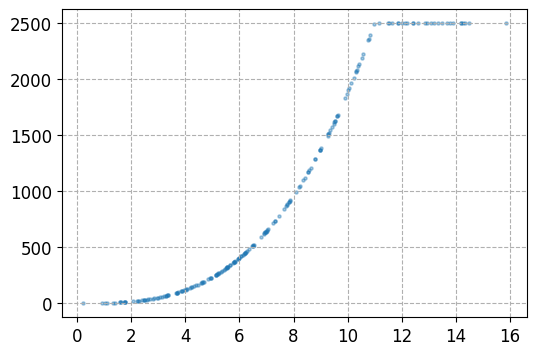

In [4]:
ws = generator.sample_x()
pw = generator.true_signal(ws)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(ws, pw, s=5, alpha=.4)

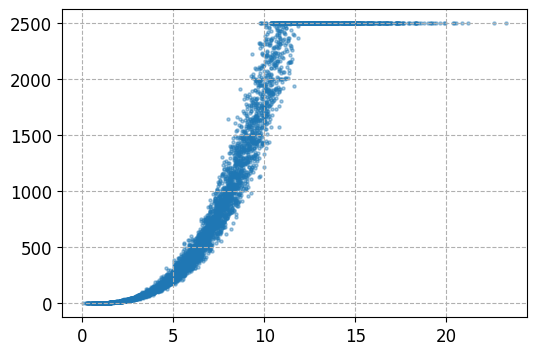

In [5]:
ws, pw = generator.training_data(n_samples=5000, to_torch=False)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.scatter(ws, pw, s=5, alpha=.4)


## Fit model

In [7]:
train_x, train_y = generator.training_data(n_samples=2000)
train_y /= generator.power_rated

model = BaseExactGP(
    train_x,
    train_y,
    mean_module=HyperbolicTangentMean(),
)

In [9]:
model.fit(train_x, train_y);

04:37:42 INFO: Iter 1 of 250: Noise:  0.002 - Loss: -1.553
04:37:45 INFO: Iter 25 of 250: Noise:  0.003 - Loss: -1.553
04:37:48 INFO: Iter 50 of 250: Noise:  0.003 - Loss: -1.554
04:37:51 INFO: Iter 75 of 250: Noise:  0.003 - Loss: -1.554
04:37:54 INFO: Iter 100 of 250: Noise:  0.003 - Loss: -1.554
04:37:56 INFO: Iter 125 of 250: Noise:  0.003 - Loss: -1.554
04:37:59 INFO: Iter 150 of 250: Noise:  0.003 - Loss: -1.554
04:38:02 INFO: Iter 175 of 250: Noise:  0.003 - Loss: -1.554
04:38:05 INFO: Iter 200 of 250: Noise:  0.003 - Loss: -1.554
04:38:08 INFO: Iter 225 of 250: Noise:  0.003 - Loss: -1.554
04:38:11 INFO: Iter 250 of 250: Noise:  0.003 - Loss: -1.554
/home/songz/Learning/pygp-sandox/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
04:38:12 INFO: Prediction scores:
+--------+--------+-----------+--------+-------+--------+-------+
| target |  bias  

## Visu

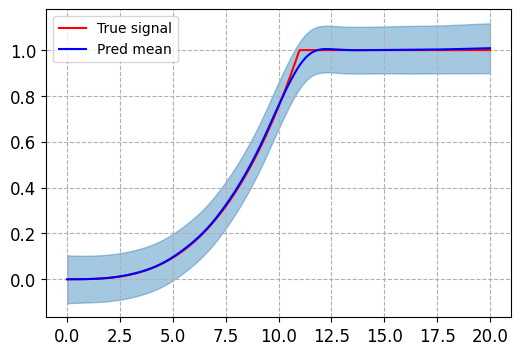

In [10]:
test_x = np.linspace(0, 20, 501)
test_y = generator.true_signal(test_x) / generator.power_rated

f_x, upper, lower = model.predict(test_x)

_, ax = plt.subplots(figsize=(6, 4))
ax.grid(ls='--')

ax.plot(test_x, test_y, c='r', label='True signal')
ax.plot(test_x, f_x.mean, c='blue', label='Pred mean')
ax.fill_between(
    test_x,
    lower,
    upper,
    color='tab:blue',
    alpha=.4,
)

ax.legend()

[None]

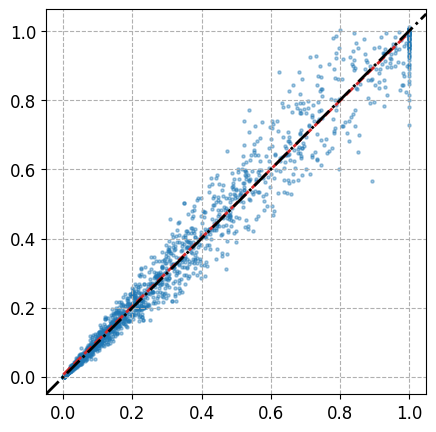

In [19]:
test_x, test_y = generator.training_data(n_samples=2000)
test_y /= generator.power_rated

f_x = model.predict(test_x, False)

_, ax = plt.subplots(figsize=(6, 5))
ax.grid(ls='--')

sns.regplot(
    x=test_y.numpy(),
    y=f_x.mean.numpy(),
    scatter_kws=dict(
        s=5,
        alpha=.4
    ),
    line_kws=dict(
        ls='--',
        lw=2,
        color='tab:red',
    )
),

ax.axline((0, 0), slope=1, ls='-.', lw=2, c='k')
ax.set(aspect='equal')